In [254]:
import matplotlib.pyplot as plt
from t4gpd.io.CirReader import CirReader
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import geopandas
from math import *
from numpy.random import randint
from shapely.geometry import LineString,Point
from t4gpd.commons.GeomLib import GeomLib
from t4gpd.demos.GeoDataFrameDemos import GeoDataFrameDemos
from t4gpd.morph.geoProcesses.FootprintExtruder import FootprintExtruder
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
import random
from t4gpd.commons.RayCasting3Lib import RayCasting3Lib
import timeit
from matplotlib.gridspec import GridSpec
from pandas import concat,merge
from t4gpd.pyvista.commons.RayCasting3DLib import RayCasting3DLib
from t4gpd.pyvista.geoProcesses.RayCasting3D import RayCasting3D
from t4gpd.pyvista.STRaysToViewFactors import STRaysToViewFactors
from t4gpd.pyvista.geoProcesses.MoveSensorsAwayFromSurface import MoveSensorsAwayFromSurface

# Functions

In [2]:
def SurfaceNormal(self): #input is the buildingsIn3d.geometry[i],than choose the polygon of one facet
    coord = self.exterior.coords
    facet_p0=np.array(coord[0])
    facet_p1=np.array(coord[1])
    facet_p2=np.array(coord[2])
    vec1 = facet_p1 - facet_p0
    vec2 = facet_p2 - facet_p1
    a = vec1[1]*vec2[2]-vec1[2]*vec2[1]
    b = vec1[2]*vec2[0]-vec1[0]*vec2[2]
    c = vec1[0]*vec2[1]-vec1[1]*vec2[0]
    normal = np.array([a,b,c])
    mod = module(normal)
    n  = normal/mod
    return n

In [3]:
def module(vector):
    return np.sqrt(np.dot(np.array(vector),np.array(vector)))

In [4]:
def VectorAngleCos(vector1,vector2):#calculate the angle between two vectors
    unit_vector1 = vector1/np.linalg.norm(vector1)
    unit_vector2 = vector2/np.linalg.norm(vector2)
    dot_vector = np.dot(unit_vector1,unit_vector2)
    return dot_vector

In [5]:
def STEvenPoints(face,n,m): #row=n, column=m
    p = face.exterior.coords
    vec1 = np.array(p[2])-np.array(p[1])
    vec2 = np.array(p[1])-np.array(p[0])
    L1 = vec1/n
    L2 = vec2/m
    s = []
    normal = []
    for i in range(1,n+1):
        for j in range(1,m+1):
            point_1 = np.array(p[0])+L2*(j-1)+L1*(i-1)
            point_2 = np.array(p[0])+L2*j+L1*i
            point_c = Point((point_1+point_2)/2)
            s.append(point_c)
            normal.append(SurfaceNormal(face))
    p_geodata = GeoDataFrame({'geometry':s},crs='epsg:2154')
    p_geodata['NormalVector'] = normal
    return p_geodata

In [6]:
def SelectRay(vec0,vec1,ray,method):#transform into 2d
    if method=='horizontal':
        v0 = np.array([vec0[0],vec0[1]])#here v0 is the left point
        v1 = np.array([vec1[0],vec1[1]])
        r = np.array([ray[0],ray[1]])
    if method=='vertical':
        v0 = np.array([vec0[1],vec0[2]])#here v0 is the taller point
        v1 = np.array([vec1[1],vec1[2]])
        r = np.array([ray[1],ray[2]])

    x = v0[0]*r[1]-v0[1]*r[0]
    y = v1[0]*r[1]-v1[1]*r[0]
    if x<=0 and y>=0:
        return True
    else:
        return False

In [7]:
def OnSurface(self,point):
    ang = 0
    p = np.array(point)
    coord = self.exterior.coords
    for i in range(len(coord)-1):
        vec1 = np.array(coord[i]) - p
        vec2 = np.array(coord[i+1])-p
        m1 = module(vec1)
        m2 = module(vec2)
        if cmp(m1*m2,0):
            return True
        else:
            cost = np.dot(vec1,vec2)/(m1*m2)
        if cost>1:
            cost = 1
        if cost<-1:
            cost = -1
        ang = ang +np.arccos(cost)
    return cmp(ang,2*np.pi)

In [8]:
def centroid(self): #rectangle centroid
    coord = self.exterior.coords
    face_p0=np.array(coord[0])
    face_p2=np.array(coord[2])
    face_ce=(face_p0+face_p2)/2
    return Point(face_ce)

In [9]:
def intersection(ray,sensor,surface):
    n = SurfaceNormal(surface)
    coords = surface.exterior.coords
    point = np.array(sensor.geometry)
    vec = np.array(coords[1])-point
    con1 = ray.dot(n)
    con2 = vec.dot(n)
    ratio = con2/con1
    if con1>0:
        return False
    else:
        in_point = point + ratio*ray
        if OnSurface(surface,Point(in_point)):
            return ratio
        else:
            return False

In [185]:
def grid3d(self,n,m):#n rows, m columns
    coord = self.exterior.coords
    p0=np.array(coord[0])
    p1=np.array(coord[1])
    p2=np.array(coord[2])
    p3=np.array(coord[3])
    vec1 = (p1-p0)/m
    vec2 = (p2-p1)/n
    poly=[]
    cen_p=[]
    sur_area=[]
    normal=[]
    sur_d=[]
    for i in range(n):
        for j in range(m):
            p0_t=Point(p0+j*vec1+i*vec2)
            p1_t=Point(p0+(j+1)*vec1+i*vec2)
            p2_t=Point(p0+(j+1)*vec1+(i+1)*vec2)
            p3_t=Point(p0+j*vec1+(i+1)*vec2)
            face_t = Polygon([p0_t,p1_t,p2_t,p3_t,p0_t])
            poly.append(face_t)
            cen_p.append(centroid(face_t))
            sur_area.append(area3d(face_t))
            normal.append(SurfaceNormal(face_t))
            sur_d.append(Surface_diameter(face_t))
    self_grid=GeoDataFrame({'geometry': poly},crs='epsg:2154')
    self_grid['CentroidPoint']=cen_p
    self_grid['area']=sur_area
    self_grid['NormalVector']=normal
    self_grid['diameter']=sur_d
    return self_grid

In [11]:
def cmp(a,b,c=1e-3):
    return abs(a-b)<c

In [12]:
def Surface_diameter(surface):
    coord = surface.exterior.coords
    d = distance3d(Point(coord[0]),Point(coord[2]))
    return d

In [13]:
def RayPoint2(point,n,norm,length):
    ray_line = []
    vec = RandomDir(n)
    for i in range(len(vec)):
        vec1 = vec[i]
        x2 = norm[0]*vec1[1]+norm[1]*vec1[0]
        y2 = norm[1]*vec1[1]-norm[0]*vec1[0]
        z2 = vec1[2]
        p2 = Point(point.x+x2*length,point.y+y2*length,point.z+z2*length)
        ray_vec = np.array([p2.x,p2.y,p2.z]) - np.array([point.x,point.y,point.z])
        ray_line.append(ray_vec)
    return ray_line

In [14]:
def distance3d(point1,point2):
    d = sqrt((point1.x-point2.x)**2 + (point1.y-point2.y)**2 + (point1.z-point2.z)**2)
    return d

In [15]:
def RandomDir(n):#number of samples
    vector = []
    for i in range(n):
        polar = 0.5*np.arccos(1-2*random.random())
        azimuth = random.random()*pi*2
        x = cos(polar)*sin(azimuth)
        y = sin(polar)
        z = cos(polar)*cos(azimuth)
        vector.append(np.array([x,y,z]))
    return vector

In [16]:
#get area from 3d polygon
def area3d(self):
    coord = self.exterior.coords
    d1 = distance3d(Point(coord[0]),Point(coord[1]))
    d2 = distance3d(Point(coord[1]),Point(coord[2]))
    return d1*d2

In [17]:
def vf_nusselt(face1,face2): #emitting from face1 accept by face2
    pt1 = face1.CentroidPoint
    pt2 = face2.CentroidPoint
    n1 = face1.NormalVector
    n2 = face2.NormalVector
    vec = np.array(pt2)-np.array(pt1)
    a2 = face2.area
    r = distance3d(pt1,pt2)
    vf = -a2*VectorAngleCos(n1,vec)*VectorAngleCos(n2,vec)/(pi*r**2)
    return vf

In [195]:
def CreateFaces(x,y,method): #x=w/d, y=h/d
    k = y/x
    polygon1 = []
    polygon2 = []
    coords_3d_1 = np.array([[10,0,0], [0,0,0], [0,0,10*k], [10,0,10*k], [10,0,0]])
    if method == 'parallel':
        coords_3d_2 = np.array([[0,10/x,0], [10,10/x,0], [10,10/x,10*k], [0,10/x,10*k], [0,10/x,0]])
    elif method == 'vertical':
        coords_3d_2 = np.array([[0,0,0], [10,0,0], [10,10/x,0], [0,10/x,0], [0,0,0]])
    else:
        return 'Please select your method "parallel" or "vertical"?'
    polygon1.append(Polygon(coords_3d_1))
    polygon2.append(Polygon(coords_3d_2))
    f1 = GeoDataFrame({'geometry':polygon1},crs='epsg:2154')
    f2 = GeoDataFrame({'geometry':polygon2},crs='epsg:2154')
    
    f1['area'] = area3d(f1.geometry.iloc[0])
    f2['area'] = area3d(f2.geometry.iloc[0])
    
    f1['diameter'] = Surface_diameter(f1.geometry.iloc[0])
    f2['diameter'] = Surface_diameter(f2.geometry.iloc[0])
    
    f1['CentroidPoint'] = centroid(f1.geometry.iloc[0])
    f2['CentroidPoint'] = centroid(f2.geometry.iloc[0])
    
    n1=[]
    n2=[]
    n1.append(SurfaceNormal(f1.geometry.iloc[0]))
    n2.append(SurfaceNormal(f2.geometry.iloc[0]))
    f1['NormalVector'] = n1
    f2['NormalVector'] = n2
    return f1,f2

In [20]:
def CreateFaces_share(theta): #x=w/d, y=h/d
    polygon1 = []
    polygon2 = []
    coords_3d_1 = np.array([[10,0,0], [0,0,0], [0,0,10], [10,0,10], [10,0,0]])
    coords_3d_2 = np.array([[0,0,0], [10,0,0], [10,10*sin(theta),10*cos(theta)], [0,10*sin(theta),10*cos(theta)], [0,0,0]])

    polygon1.append(Polygon(coords_3d_1))
    polygon2.append(Polygon(coords_3d_2))
    f1 = GeoDataFrame({'geometry':polygon1},crs='epsg:2154')
    f2 = GeoDataFrame({'geometry':polygon2},crs='epsg:2154')
    
    f1['area'] = area3d(f1.geometry.iloc[0])
    f2['area'] = area3d(f2.geometry.iloc[0])
    
    f1['diameter'] = Surface_diameter(f1.geometry.iloc[0])
    f2['diameter'] = Surface_diameter(f2.geometry.iloc[0])
    
    f1['CentroidPoint'] = centroid(f1.geometry.iloc[0])
    f2['CentroidPoint'] = centroid(f2.geometry.iloc[0])
    return f1,f2

In [21]:
def ParallelVF(a,b):#a=width/distance,b=height/distance
    f = 2/(pi*a*b)*(log(((1+a**2)*(1+b**2)/(1+a**2+b**2))**0.5)+
                    (a*(1+b**2)**0.5)*atan(a/(1+b**2)**0.5)+
                    (b*(1+a**2)**0.5)*atan(b/(1+a**2)**0.5)-
                    a*atan(a)-
                    b*atan(b))
    return f

In [187]:
#Subdivide function 2
def Subdivide2(f1,f2): #f1 is the emitting surface, f2 is the target surface
    if isFiveTimeRuleOk(f1,f2):
        return [f1]
    else:
        d = distance3d(f1.CentroidPoint,f2.CentroidPoint)/5
        coord1 = f1.geometry.exterior.coords
        w1 = distance3d(Point(coord1[0]),Point(coord1[1]))
        h1 = distance3d(Point(coord1[1]),Point(coord1[2]))
        
        n1 = int(h1/d)+1
        m1 = int(w1/d)+1
        
        x = grid3d(f1.geometry,n1,m1)
        return x

In [23]:
def Subdivide(f1,f2): #f1 is the emitting surface, f2 is the target surface
    if isFiveTimeRuleOk(f1,f2):
        return [f1]
    else:
        result = []
        f_grid = grid3d(f1.geometry,2,2)
        for i in range(len(f_grid)):
            if isFiveTimeRuleOk(f_grid.iloc[i],f2):
                result.append(f_grid.iloc[i])
            else:
                result += Subdivide(f_grid.iloc[i],f2)
        return result

In [24]:
def isFiveTimeRuleOk(f1,f2):
    return distance3d(f1.CentroidPoint,f2.CentroidPoint) >= 5*f1.diameter

In [25]:
def isa(face1,face2):#view factor from 1 to 2
    n1=SurfaceNormal(face1.geometry)
    n2=SurfaceNormal(face2.geometry)
    a2=area3d(face2.geometry)
    vec_R=np.array([face1.CentroidPoint.x-face2.CentroidPoint.x,face1.CentroidPoint.y-face2.CentroidPoint.y,face1.CentroidPoint.z-face2.CentroidPoint.z])
    vf=-a2*np.dot(n1,vec_R)*np.dot(n2,vec_R)/(pi*module(vec_R)**4)
    return vf

In [83]:
def newMonteCarlo(f1,f2,nb_ray,n,m,times):
    g1 = grid3d(f1.geometry.squeeze(),n,m)
    g2 = grid3d(f2.geometry.squeeze(),n,m)
    masks = concat([g1,g2])
    masks.reset_index(inplace=True, drop=True)
    masks['pk'] = masks.index
    
    sensors = GeoDataFrame({'geometry':list(masks.CentroidPoint)},crs='epsg:2154')
    sensors['NormalVector'] = list(masks.NormalVector)
    sensors['pk'] = list(masks.pk)
    op1 = MoveSensorsAwayFromSurface(sensors,normalFieldname='NormalVector',dist=1e-10)
    sensors = STGeoProcess(op1,sensors).execute()
    
    viewfactor = []
    
    coords = f2.geometry[0].exterior.coords#selectray
    
    for w in range(times):
        vf = []
        #shootingDirs = RayCasting3DLib.preparePanopticRays(nb_ray)
        ray = RayPoint2(sensors.geometry.iloc[0],nb_ray,sensors.NormalVector.iloc[0],1)
        for i in range(int(len(sensors)/2)):
            sensor = sensors.loc[ sensors[sensors.pk == i].index ]
            
            #select ray
            point = np.array(sensor.geometry.squeeze())
            vec0 = np.array(coords[0])-point
            vec1 = np.array(coords[1])-point
            vec2 = np.array(coords[2])-point
            ray_vec = []
            for j in range(len(ray)):
                if SelectRay(vec2,vec0,ray[j],'vertical')==True:
                    ray_vec.append(ray[j])
            shootingDirs = np.asarray(ray_vec)
            
            #calculate viewfactor
            op2 = RayCasting3D([masks], shootingDirs, viewpoints=sensor,
                      normalFieldname='NormalVector', pkFieldname='pk')
            rays = STGeoProcess(op2, sensor).execute()
            vfSparseMatrix = STRaysToViewFactors(rays,'pk','hitGids').run()
            vf.append(sum(vfSparseMatrix.viewfactor)*len(ray_vec)/len(ray))
        viewfactor.append(sum(vf)/(len(sensors)/2))
    return np.mean(viewfactor)

In [28]:
def VerticalVF(a,b):#a = h/w , b = l/w
    f = 1/(pi*b)*(b*atan(1/b)+a*atan(1/a)-((a**2+b**2)**0.5)*atan(1/((a**2+a**2)**0.5))+0.25*log((1+b**2)*(1+a**2)/(1+b**2+a**2)*((b**2*(1+b**2+a**2)/((1+b**2)*(b**2+a**2)))**(b**2))*(a**2*(1+a**2+b**2)/((1+a**2)*(a**2+b**2)))**(a**2)))
    return f

In [29]:
def rotation(f1,theta):#counterclockwise
    self = f1.geometry.squeeze()
    coord = self.exterior.coords
    p_cen = f1.CentroidPoint.squeeze()
    x0 = (Point(coord[0]).x-p_cen.x)*cos(theta)-(Point(coord[0]).y-p_cen.y)*sin(theta)+p_cen.x
    y0 = (Point(coord[0]).y-p_cen.y)*cos(theta)+(Point(coord[0]).x-p_cen.x)*sin(theta)+p_cen.y
    x1 = (Point(coord[1]).x-p_cen.x)*cos(theta)-(Point(coord[1]).y-p_cen.y)*sin(theta)+p_cen.x
    y1 = (Point(coord[1]).y-p_cen.y)*cos(theta)+(Point(coord[1]).x-p_cen.x)*sin(theta)+p_cen.y
    p0 = Point(x0,y0,Point(coord[0]).z)
    p1 = Point(x1,y1,Point(coord[1]).z)
    p2 = Point(x1,y1,Point(coord[2]).z)
    p3 = Point(x0,y0,Point(coord[3]).z)
    face = Polygon([p0,p1,p2,p3,p0])
    f1['geometry']= face
    return f1

In [214]:
def MonteCarlo(f1,f2,nb_ray,n,m,times):
    sensors = STEvenPoints(f1.geometry[0],n,m)
    sensors['NormalVector'] = [SurfaceNormal(f1.geometry[0]) for item in sensors.geometry]
    coords = f2.geometry[0].exterior.coords

    nb_cal = []
    for w in range(times):
        nb=0
        for s in range(len(sensors)):
            p = sensors.iloc[s]
            normal = p.NormalVector
            ray = RayPoint2(p.geometry,nb_ray,normal,20)
            f2['nray'] = 0
            point = np.array(p.geometry)
            vec0 = np.array(coords[0])-point
            vec1 = np.array(coords[1])-point
            vec2 = np.array(coords[2])-point
            ray_vec = []
            for j in range(len(ray)):
                if SelectRay(vec0,vec1,ray[j],'horizontal')==True and SelectRay(vec2,vec1,ray[j],'vertical')==True:
                    ray_vec.append(ray[j])
            for a in range(len(ray_vec)):
                ratio = []
                value = intersection(ray_vec[a],p,f2.geometry[0])
                if value==False:
                    ratio.append(0)
                else:
                    ratio.append(value)
                f2['ratio'] = ratio
                mymin = min(f2.ratio)
                if f2.ratio[0]!=0:
                    f2.loc[0,'nray'] = f2.loc[0,'nray']+1
            nbs = f2.nray
            nb = nb + nbs
        nb_cal.append(nb/(len(sensors)*nb_ray))
    vf = np.mean(nb_cal)
    
    return vf

# Parallel faces

In [224]:
#L1 = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
L1 = [2,1.9,1.8,1.7,1.6,1.5,1.4,1.3,1.2,1.1]

In [225]:
import timeit

In [226]:
%%time
#nusselt
error1 = []
time1 = []
vf1 = []
vf_a = []
for j in range(len(L1)):
    start = timeit.default_timer()
    f1,f2 = CreateFaces(L1[j],L1[j],'parallel')
    d = GeoDataFrame(Subdivide2(f1.iloc[0],f2.iloc[0]))
    c = GeoDataFrame(Subdivide2(f2.iloc[0],f1.iloc[0]))
    vftest = 0
    for i in range(len(d)):
        face_0 = d.iloc[i]
        vf2_isa = [vf_nusselt(face_0,face_1) for face_1 in c.iloc]
        vftest = vftest + sum(vf2_isa)/len(d)
    vf1.append(vftest)
    vf_a.append(ParallelVF(L1[j],L1[j]))
    stop = timeit.default_timer()
    error1.append((vftest-ParallelVF(L1[j],L1[j]))/ParallelVF(L1[j],L1[j])*100)
    time1.append(stop-start)

CPU times: user 15.9 s, sys: 208 ms, total: 16.1 s
Wall time: 16.3 s


In [229]:
#isa method
error2 = []
time2 = []
vf2 = []
for j in range(len(L1)):
    f1,f2 = CreateFaces(L1[j],L1[j],'parallel')
    start = timeit.default_timer()
    grid = GeoDataFrame(Subdivide2(f2.iloc[0],f1.iloc[0]))
    vf = []
    for i in range(len(grid)):
        f2_grid = grid.iloc[i]
        list_sub = Subdivide(f1.iloc[0],f2_grid)
        testgeo = GeoDataFrame(list_sub)
        area = [area3d(item) for item in testgeo.geometry]
        testgeo['area']=area
        vf_isa = [isa(tg,f2_grid)*tg.area/100 for tg in testgeo.iloc]
        vf.append(sum(vf_isa))
    vf2.append(sum(vf))
    stop = timeit.default_timer()
    error2.append(abs(sum(vf)-ParallelVF(L1[j],L1[j]))/ParallelVF(L1[j],L1[j])*100)
    time2.append(stop-start)

In [227]:
#new Monte Carlo Ray Tracing
n = 1
m = 1
times = 5
n_ray = 10000
vf3 = []
time3 = []
error3 = []
for j in range(len(L1)):
    start = timeit.default_timer()
    f1,f2 = CreateFaces(L1[j],L1[j],'parallel')
    vf_mc = newMonteCarlo(f1,f2,n_ray,n,m,times)
    vf3.append(vf_mc)
    stop = timeit.default_timer()
    error3.append(abs(vf_mc-ParallelVF(L1[j],L1[j]))/ParallelVF(L1[j],L1[j])*100)
    time3.append(stop-start)

Elapsed time: 0.008 s (00:00:00)
Elapsed time: 0.180 s (00:00:00)
Elapsed time: 0.161 s (00:00:00)
Elapsed time: 0.161 s (00:00:00)
Elapsed time: 0.163 s (00:00:00)
Elapsed time: 0.161 s (00:00:00)
Elapsed time: 0.009 s (00:00:00)
Elapsed time: 0.151 s (00:00:00)
Elapsed time: 0.152 s (00:00:00)
Elapsed time: 0.152 s (00:00:00)
Elapsed time: 0.152 s (00:00:00)
Elapsed time: 0.148 s (00:00:00)
Elapsed time: 0.008 s (00:00:00)
Elapsed time: 0.168 s (00:00:00)
Elapsed time: 0.157 s (00:00:00)
Elapsed time: 0.147 s (00:00:00)
Elapsed time: 0.143 s (00:00:00)
Elapsed time: 0.144 s (00:00:00)
Elapsed time: 0.007 s (00:00:00)
Elapsed time: 0.138 s (00:00:00)
Elapsed time: 0.139 s (00:00:00)
Elapsed time: 0.135 s (00:00:00)
Elapsed time: 0.142 s (00:00:00)
Elapsed time: 0.139 s (00:00:00)
Elapsed time: 0.007 s (00:00:00)
Elapsed time: 0.142 s (00:00:00)
Elapsed time: 0.142 s (00:00:00)
Elapsed time: 0.142 s (00:00:00)
Elapsed time: 0.136 s (00:00:00)
Elapsed time: 0.133 s (00:00:00)
Elapsed ti

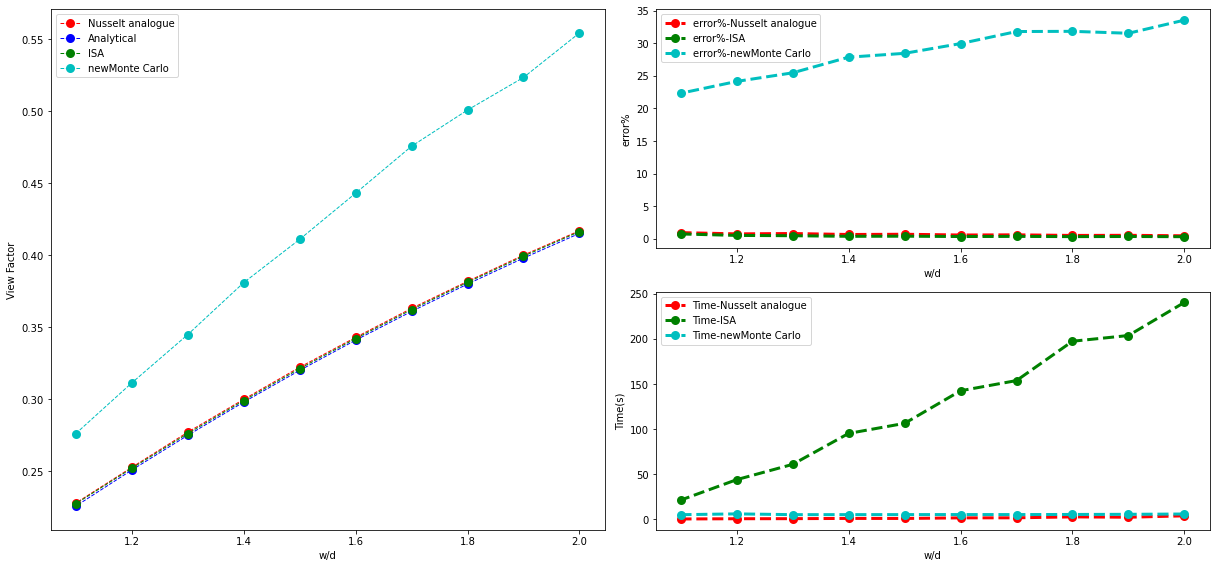

In [231]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)

ax0 = fig.add_subplot(gs[:,0])
ax0.plot(L1,vf1,'r--',label = 'Nusselt analogue',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L1,vf_a,'b--',label = 'Analytical',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L1,vf2,'g--',label = 'ISA',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L1,vf3,'c--',label = 'newMonte Carlo',linewidth=1,marker='o',markeredgewidth=3)
ax0.set(xlabel='w/d',ylabel='View Factor')
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(L1,error1,'r--',label = 'error%-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L1,error2,'g--',label = 'error%-ISA',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L1,error3,'c--',label = 'error%-newMonte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='w/d',ylabel='error%')
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(L1,time1,'r--',label = 'Time-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L1,time2,'g--',label = 'Time-ISA',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L1,time3,'c--',label = 'Time-newMonte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax2.set(xlabel='w/d',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/aogecui/Desktop/实习项目/fig/L2.png',dpi=500)

# Vertical to ground but not parallel

In [232]:
L4 = [0.1*pi,0.2*pi,0.3*pi,0.4*pi]

In [238]:
#isa method
time5 = []
vf5 = []
for j in range(len(L4)):
    f1,f2 = CreateFaces(1,1,'parallel')
    f2 = rotation(f2,L4[j])
    start = timeit.default_timer()
    grid = GeoDataFrame(Subdivide2(f2.iloc[0],f1.iloc[0]))
    vf = []
    for i in range(len(grid)):
        f2_grid = grid.iloc[i]
        list_sub = Subdivide(f1.iloc[0],f2_grid)
        testgeo = GeoDataFrame(list_sub)
        area = [area3d(item) for item in testgeo.geometry]
        testgeo['area']=area
        vf_isa = [isa(tg,f2_grid)*tg.area/100 for tg in testgeo.iloc]
        vf.append(sum(vf_isa))
    vf5.append(sum(vf))
    stop = timeit.default_timer()
    time5.append(stop-start)

In [242]:
#nusselt
time4 = []
error4 = []
vf4 = []
for j in range(len(L4)):
    start = timeit.default_timer()
    f1,f2 = CreateFaces(1,1,'parallel')
    f2 = rotation(f2,L4[j])
    d = GeoDataFrame(Subdivide2(f1.iloc[0],f2.iloc[0]))
    c = GeoDataFrame(Subdivide2(f2.iloc[0],f1.iloc[0]))
    vftest = 0
    for i in range(len(d)):
        face_0 = d.iloc[i]
        vf2_isa = [vf_nusselt(face_0,face_1) for face_1 in c.iloc]
        vftest = vftest + sum(vf2_isa)/len(d)
    vf4.append(vftest)
    error4.append(abs(vftest-vf5[j])/vf5[j])
    stop = timeit.default_timer()
    time4.append(stop-start)

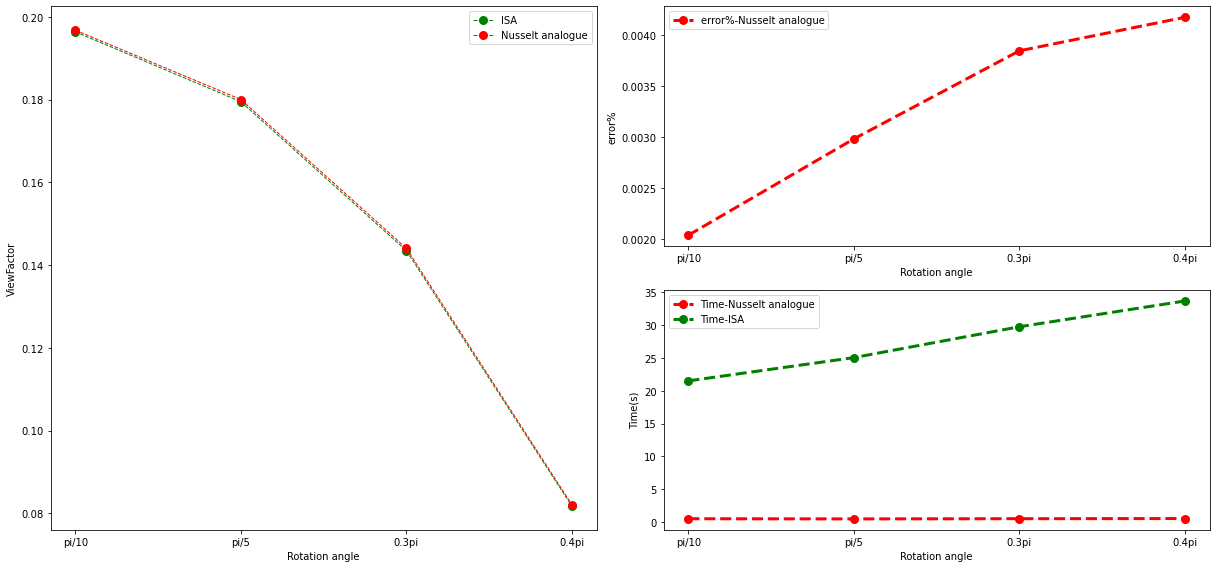

In [246]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)
group_lables = ['pi/10','pi/5','0.3pi','0.4pi']

ax0 = fig.add_subplot(gs[:,0])
ax0.plot(L4,vf5,'g--',label = 'ISA',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L4,vf4,'r--',label = 'Nusselt analogue',linewidth=1,marker='o',markeredgewidth=3)
ax0.set(xlabel='Rotation angle',ylabel='ViewFactor')
plt.xticks(L4,group_lables,rotation=0)
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(L4,error4,'r--',label = 'error%-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='Rotation angle',ylabel='error%')
plt.xticks(L4,group_lables,rotation=0)
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(L4,time4,'r--',label = 'Time-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L4,time5,'g--',label = 'Time-ISA',linewidth=3,marker='o',markeredgewidth=3)
plt.xticks(L4,group_lables,rotation=0)
ax2.set(xlabel='Rotation angle',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/aogecui/Desktop/实习项目/fig/L3.png',dpi=500)

# Rotation

In [54]:
L5 = [0.1*pi,0.2*pi,0.3*pi,0.4*pi,0.5*pi,0.6*pi,0.7*pi,0.8*pi,0.9*pi]

In [55]:
vf_a_r=[]
for n in range(len(L5)):
    vf_a_r.append((1-sin(L5[n]/2)))

In [247]:
#isa method
vf_isa = []
time10 =[]
error10=[]
for n in range(len(L5)):
    start = timeit.default_timer()
    f5,f6 = CreateFaces_share(L5[n])
    grid = grid3d(f6.geometry.squeeze(),3,3)
    vf = []
    for j in range(len(grid)):
        f6_grid = grid.iloc[j]
        list_sub = Subdivide(f5.iloc[0],f6_grid)
        testgeo = GeoDataFrame(list_sub)
        area = [area3d(item) for item in testgeo.geometry]
        testgeo['area'] = area
        vf_i = [isa(tg,f6_grid)*tg.area/100 for tg in testgeo.iloc]
        vf.append(sum(vf_i))
    vf_isa.append(sum(vf))
    error10.append(abs(sum(vf)-(1-sin(L5[n]/2)))/(1-sin(L5[n]/2))*100)
    stop = timeit.default_timer()
    time10.append(stop-start)

In [98]:
#Nusselt analogue
vf_nu = []
error9 = []
time9 = []
for n in range(len(L5)):
    f5,f6 = CreateFaces_share(L5[n])
    start = timeit.default_timer()
    vf2=[]
    f5_grid = grid3d(f5.geometry.squeeze(),15,15)
    f6_grid = grid3d(f6.geometry.squeeze(),15,15)
    for i in f6_grid.iloc():
        vf5=[]
        for j in f5_grid.iloc():
            vf5.append(vf_nusselt(j,i))
        vf2.append(sum(vf5)/len(f5_grid))
    vf_nu.append(sum(vf2))
    #error9.append(abs(sum(vf2)-(1-sin(L5[n]/2)))/(1-sin(L5[n]/2))*100)
    error9.append(abs(sum(vf2)-vf_isa[n])/vf_isa[n]*100)
    stop = timeit.default_timer()
    time9.append(stop-start)

In [248]:
#mont carlo
vf_mc = []
time11 = []
error11 = []
n = 3
m = 3
times = 1
n_ray = 10000
for i in range(len(L5)):
    start = timeit.default_timer()
    f5,f6 = CreateFaces_share(L5[i])
    vf = newMonteCarlo(f5,f6,n_ray,n,m,times)
    vf_mc.append(vf)
    #error11.append(abs(vf-(1-sin(L5[i]/2)))/(1-sin(L5[i]/2))*100)
    error11.append(abs(vf-vf_isa[i])/vf_isa[i]*100)
    stop = timeit.default_timer()
    time11.append(stop-start)

Elapsed time: 0.010 s (00:00:00)
Elapsed time: 0.271 s (00:00:00)
Elapsed time: 0.303 s (00:00:00)
Elapsed time: 0.301 s (00:00:00)
Elapsed time: 0.544 s (00:00:00)
Elapsed time: 0.282 s (00:00:00)
Elapsed time: 0.266 s (00:00:00)
Elapsed time: 0.211 s (00:00:00)
Elapsed time: 0.221 s (00:00:00)
Elapsed time: 0.205 s (00:00:00)
Elapsed time: 0.010 s (00:00:00)
Elapsed time: 0.237 s (00:00:00)
Elapsed time: 0.257 s (00:00:00)
Elapsed time: 0.265 s (00:00:00)
Elapsed time: 0.210 s (00:00:00)
Elapsed time: 0.226 s (00:00:00)
Elapsed time: 0.215 s (00:00:00)
Elapsed time: 0.124 s (00:00:00)
Elapsed time: 0.136 s (00:00:00)
Elapsed time: 0.122 s (00:00:00)
Elapsed time: 0.009 s (00:00:00)
Elapsed time: 0.201 s (00:00:00)
Elapsed time: 0.230 s (00:00:00)
Elapsed time: 0.221 s (00:00:00)
Elapsed time: 0.149 s (00:00:00)
Elapsed time: 0.169 s (00:00:00)
Elapsed time: 0.147 s (00:00:00)
Elapsed time: 0.089 s (00:00:00)
Elapsed time: 0.095 s (00:00:00)
Elapsed time: 0.106 s (00:00:00)
Elapsed ti

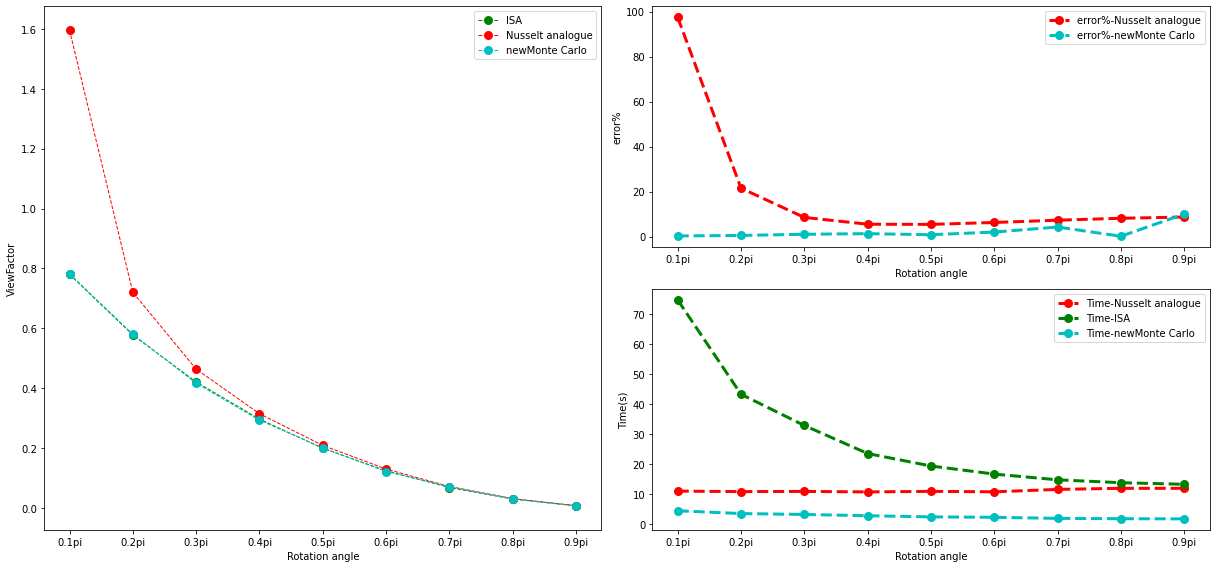

In [252]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)
group_lables = ['0.1pi','0.2pi','0.3pi','0.4pi','0.5pi','0.6pi','0.7pi','0.8pi','0.9pi']

ax0 = fig.add_subplot(gs[:,0])
#ax0.plot(L5,vf_a_r,'b--',label = 'Analytical',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L5,vf_isa,'g--',label = 'ISA',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L5,vf_nu,'r--',label = 'Nusselt analogue',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L5,vf_mc,'c--',label = 'newMonte Carlo',linewidth=1,marker='o',markeredgewidth=3)
ax0.set(xlabel='Rotation angle',ylabel='ViewFactor')
plt.xticks(L5,group_lables,rotation=0)
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
#ax1.plot(L5,error10,'g--',label = 'error%-ISA',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L5,error9,'r--',label = 'error%-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L5,error11,'c--',label = 'error%-newMonte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='Rotation angle',ylabel='error%')
plt.xticks(L5,group_lables,rotation=0)
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(L5,time9,'r--',label = 'Time-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L5,time10,'g--',label = 'Time-ISA',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L5,time11,'c--',label = 'Time-newMonte Carlo',linewidth=3,marker='o',markeredgewidth=3)
plt.xticks(L5,group_lables,rotation=0)
ax2.set(xlabel='Rotation angle',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/aogecui/Desktop/实习项目/fig/L4.png',dpi=500)